# Physics-informed neural network for 2D Laplace equation

- PDE: $\displaystyle \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0$
- Domain: $x \in [0, a], y \in [0, b]$
- Boundary conditions: $\displaystyle u(x, 0) = 0, u(x, b)=\frac{\sin(\omega x)}{\sin(\omega a)}, u(0, y) = 0, u(a, y) = \frac{\sinh(\omega y)}{\sinh(\omega b)}$

**Analytical Solution**
$$
u(x, y) = \frac{\sin(\omega x)}{\sin(\omega a)}\frac{\sinh(\omega y)}{\sinh(\omega b)}
$$

## Analytical solution

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
a = 9
b = 3
N = 100
x = np.linspace(0, a, N)
y = np.linspace(0, b, N)

X, Y = np.meshgrid(x, y)

def u(x, y):
    return (np.sin(x) * np.sinh(y)) / (np.sin(a) * np.sinh(b))

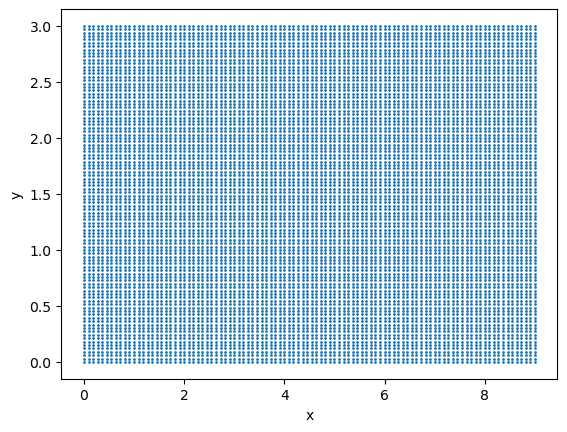

In [ ]:
fig, ax = plt.subplots()

ax.scatter(X.ravel(), Y.ravel(), s=1)

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

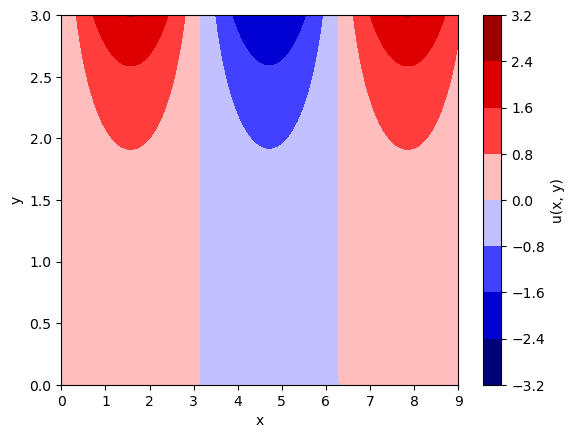

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cf = ax.contourf(X, Y, u(X, Y), cmap='seismic')
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label('u(x, y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

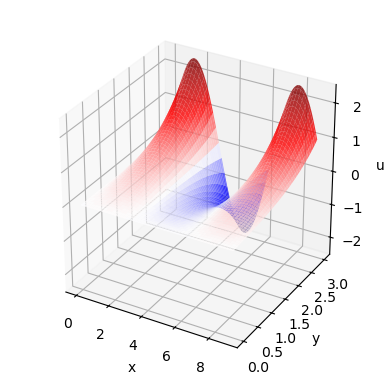

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u(X, Y), cmap='seismic', alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_box_aspect((1,1,1), zoom=0.9)
plt.show()

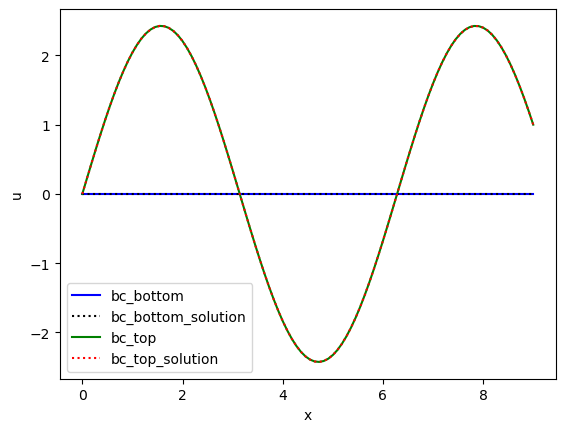

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, np.zeros(N), 'b-', label='bc_bottom')
ax.plot(x, u(x, 0), 'k:', label='bc_bottom_solution')

ax.plot(x, np.sin(x)/np.sin(a), 'g-', label='bc_top')
ax.plot(x, u(x, b), 'r:', label='bc_top_solution')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('u')

plt.show()

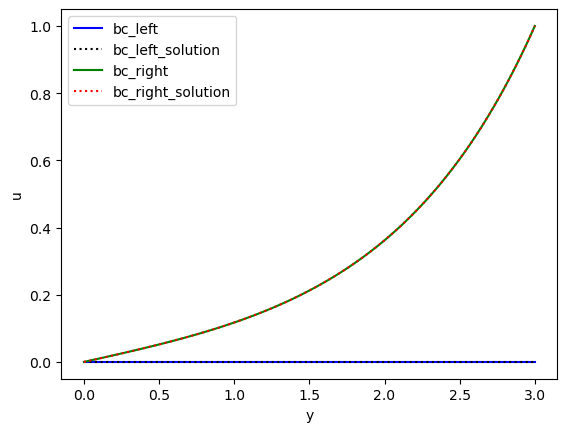

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(y, np.zeros(N), 'b-', label='bc_left')
ax.plot(y, u(0, y), 'k:', label='bc_left_solution')

ax.plot(y, np.sinh(y)/np.sinh(b), 'g-', label='bc_right')
ax.plot(y, u(a, y), 'r:', label='bc_right_solution')

ax.legend()
ax.set_xlabel('y')
ax.set_ylabel('u')

plt.show()

## PINN

In [ ]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings; warnings.simplefilter('ignore')

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x, y):
        return self.model(torch.hstack([x, y]))

In [ ]:
# Solution function u as Neural Networks
u_NN = MLP().to(device)

In [ ]:
def u_test(u_NN):
    N = 100
    x_test = torch.linspace(0, a, N).to(device)
    y_test = torch.linspace(0, b, N).to(device)
    
    X_test, Y_test = torch.meshgrid(x_test, y_test, indexing='ij')

    u_test = u_NN(X_test.reshape(-1, 1), Y_test.reshape(-1, 1))
    
    X_test_numpy = X_test.detach().cpu().numpy()
    Y_test_numpy = Y_test.detach().cpu().numpy()
    u_test_numpy = u_test.detach().cpu().numpy().reshape(N, N)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X_test_numpy.ravel(), Y_test_numpy.ravel(), s=1)
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('y', fontsize=20)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(6,6))
    cp = ax.contourf(X_test_numpy, Y_test_numpy, u_test_numpy, cmap='seismic')
    # fig.colorbar(cp)
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('y', fontsize=20)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(6,6),subplot_kw={"projection": "3d"})
    cp = ax.plot_surface(X_test_numpy, Y_test_numpy, u_test_numpy, cmap='seismic', alpha=0.8)
    fig.colorbar(cp)
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('y', fontsize=20)
    plt.show()
    
    
    # Check BC (bottom/top)
    x_test_bottom = x_test.reshape(-1, 1)
    y_test_bottom = torch.full((N, 1), 0.0).to(device)
    u_test_bottom = u_NN(x_test_bottom, y_test_bottom)
    
    x_test_top = x_test.reshape(-1, 1)
    y_test_top = torch.full((N, 1), b).to(device)
    u_test_top = u_NN(x_test_top, y_test_top)
    
    x_test_bottom_numpy = x_test_bottom.detach().cpu().numpy()
    u_test_bottom_numpy = u_test_bottom.detach().cpu().numpy()
    
    x_test_top_numpy = x_test_top.detach().cpu().numpy()
    u_test_top_numpy = u_test_top.detach().cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(x_test_bottom_numpy, np.zeros(N), 'b-', label='bc_bottom')
    ax.plot(x_test_bottom_numpy, u_test_bottom_numpy, 'k:', label='bc_bottom_solution')
    ax.plot(x_test_top_numpy, np.sin(x_test_top_numpy)/np.sin(a), 'g-', label='bc_top')
    ax.plot(x_test_top_numpy, u_test_top_numpy, 'r:', label='bc_top_solution')
    ax.legend()
    ax.set_xlabel('x', fontsize=20)
    ax.set_ylabel('u', fontsize=20)
    plt.show()
    
    # Check BC (left/right)
    x_test_left = torch.full((N, 1), 0.0).to(device)
    y_test_left = y_test.reshape(-1, 1)
    u_test_left = u_NN(x_test_left, y_test_left)
    
    x_test_right = torch.full((N, 1), a).to(device)
    y_test_right = y_test.reshape(-1, 1)
    u_test_right = u_NN(x_test_right, y_test_right)
    
    y_test_left_numpy = y_test_left.detach().cpu().numpy()
    u_test_left_numpy = u_test_left.detach().cpu().numpy()
    
    y_test_right_numpy = y_test_right.detach().cpu().numpy()
    u_test_right_numpy = u_test_right.detach().cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(y_test_left_numpy, np.zeros(N), 'b-', label='bc_left')
    ax.plot(y_test_left_numpy, u_test_left_numpy, 'k:', label='bc_left_solution')
    ax.plot(y_test_right_numpy, np.sinh(y_test_right_numpy)/np.sinh(b), 'g-', label='bc_right')
    ax.plot(y_test_right_numpy, u_test_right_numpy, 'r:', label='bc_right_solution')
    ax.legend()
    ax.set_xlabel('y', fontsize=20)
    ax.set_ylabel('u', fontsize=20)
    plt.show()

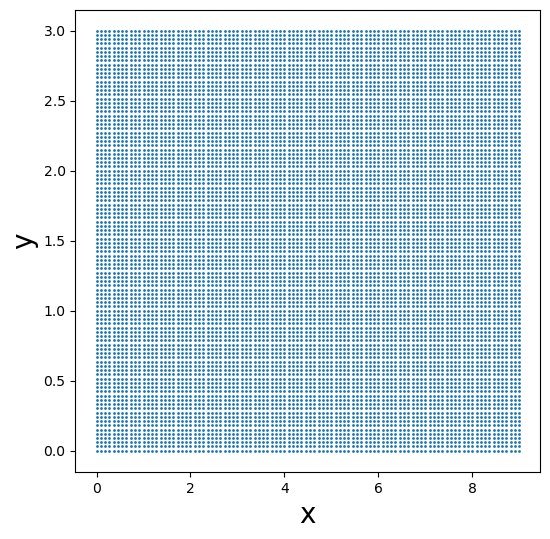

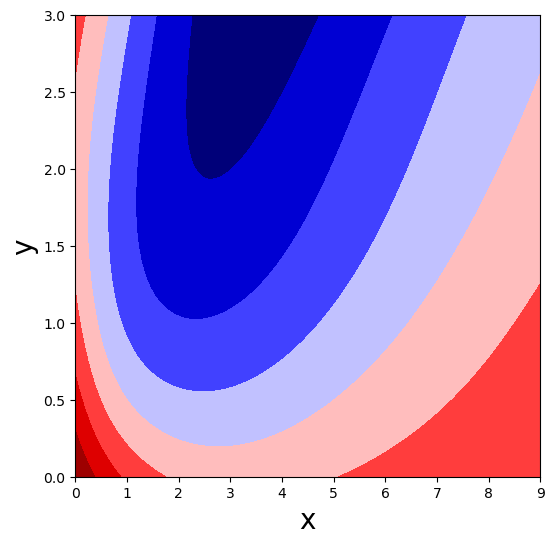

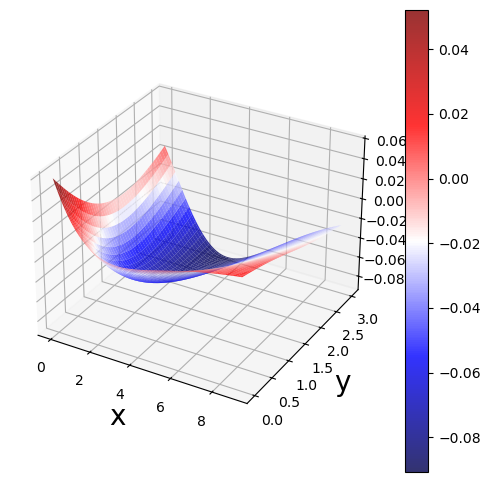

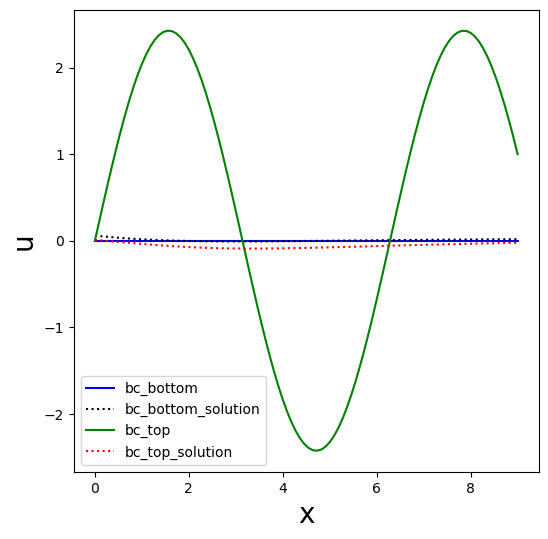

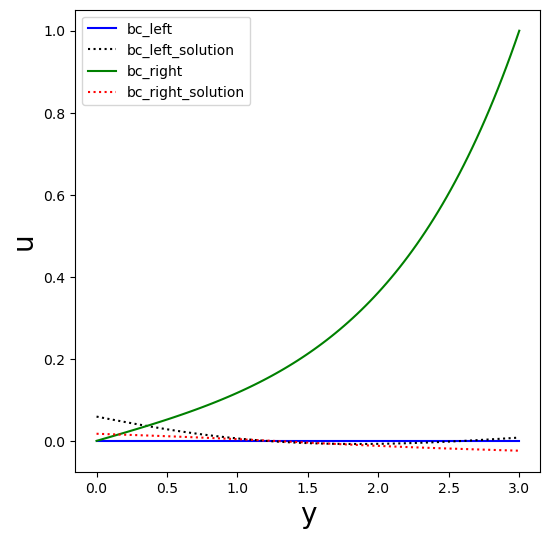

In [ ]:
u_test(u_NN)

In [ ]:
# boundary points
N_bc = 16

x_bottom = torch.FloatTensor(N_bc, 1).uniform_(0, a).to(device)
y_bottom = torch.zeros(N_bc, 1).to(device)

x_top = torch.FloatTensor(N_bc, 1).uniform_(0, a).to(device)
y_top = torch.full((N_bc, 1), b).to(device)

x_left = torch.zeros(N_bc, 1).to(device)
y_left = torch.FloatTensor(N_bc, 1).uniform_(0, b).to(device)

x_right = torch.full((N_bc, 1), a).to(device)
y_right = torch.FloatTensor(N_bc, 1).uniform_(0, b).to(device)

# boundary condition
u_bc_bottom = torch.full((N_bc, 1), 0.0).to(device)
u_bc_top = torch.sin(x_top) / np.sin(a)
u_bc_left = torch.full((N_bc, 1), 0.0).to(device)
u_bc_right = torch.sinh(y_right) / np.sinh(b)

# collocation points
N_co = 128

x_co = torch.FloatTensor(N_co, 1).uniform_(0, a)
x_co.requires_grad = True
x_co = x_co.to(device)

y_co = torch.FloatTensor(N_co, 1).uniform_(0, b)
y_co.requires_grad = True
y_co = y_co.to(device)

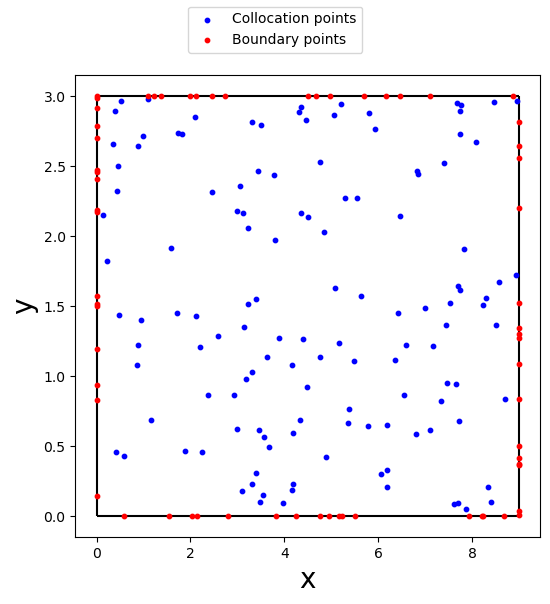

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.vlines([0, a], 0, b, colors='black', zorder=0)
ax.hlines([0, b], 0, a, colors='black', zorder=0)
ax.scatter(x_co.detach().cpu().numpy(), y_co.detach().cpu().numpy(), color='blue', label='Collocation points', s=10)
ax.scatter(x_bottom.detach().cpu().numpy(), y_bottom.detach().cpu().numpy(), color='red', label='Boundary points', s=10)
ax.scatter(x_top.detach().cpu().numpy(), y_top.detach().cpu().numpy(), color='red', s=10)
ax.scatter(x_left.detach().cpu().numpy(), y_left.detach().cpu().numpy(), color='red', s=10)
ax.scatter(x_right.detach().cpu().numpy(), y_right.detach().cpu().numpy(), color='red', s=10)
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
fig.legend(loc='upper center')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.get_xaxis().set_ticks([])
# ax.get_yaxis().set_ticks([])
# ax.set_xlim(0, a)
# ax.set_ylim(0, b)
# plt.savefig('points.png', dpi=300, bbox_inches='tight')

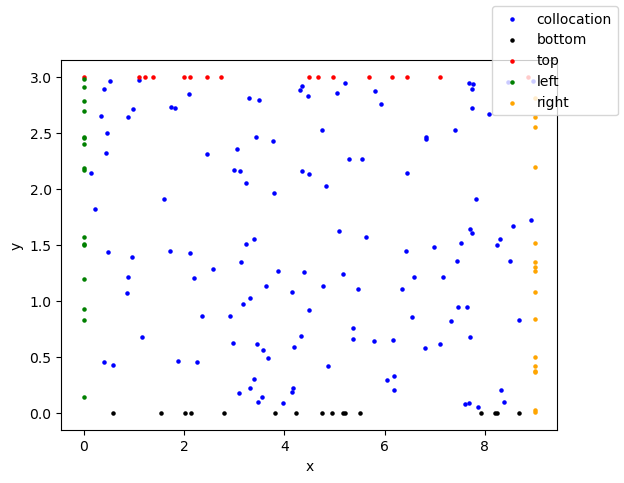

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x_co.detach().cpu().numpy(), y_co.detach().cpu().numpy(), color='blue', label='collocation', s=5)
ax.scatter(x_bottom.detach().cpu().numpy(), y_bottom.detach().cpu().numpy(), color='black', label='bottom', s=5)
ax.scatter(x_top.detach().cpu().numpy(), y_top.detach().cpu().numpy(), color='red', label='top', s=5)
ax.scatter(x_left.detach().cpu().numpy(), y_left.detach().cpu().numpy(), color='green', label='left', s=5)
ax.scatter(x_right.detach().cpu().numpy(), y_right.detach().cpu().numpy(), color='orange', label='right', s=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.legend()
plt.show()

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(u_NN.parameters(), lr=0.0001)

# Loss function
mseloss = nn.MSELoss(reduction='mean')
lambda_bc = 1
lambda_de = 1

In [ ]:
from time import perf_counter
from tqdm import tqdm

In [ ]:
# Iterations
iterations = 10000

losses = {'loss':[], 'loss_bc':[], 'loss_de':[]}

t1 = perf_counter()
tqdm_iter = tqdm(range(iterations))
for i in tqdm_iter:

    # boundary points
    N_bc = 16

    x_bottom = torch.FloatTensor(N_bc, 1).uniform_(0, a).to(device)
    y_bottom = torch.zeros(N_bc, 1).to(device)

    x_top = torch.FloatTensor(N_bc, 1).uniform_(0, a).to(device)
    y_top = torch.full((N_bc, 1), b).to(device)

    x_left = torch.zeros(N_bc, 1).to(device)
    y_left = torch.FloatTensor(N_bc, 1).uniform_(0, b).to(device)

    x_right = torch.full((N_bc, 1), a).to(device)
    y_right = torch.FloatTensor(N_bc, 1).uniform_(0, b).to(device)

    # boundary condition
    u_bc_bottom = torch.full((N_bc, 1), 0.0).to(device)
    u_bc_top = torch.sin(x_top) / np.sin(a)
    u_bc_left = torch.full((N_bc, 1), 0.0).to(device)
    u_bc_right = torch.sinh(y_right) / np.sinh(b)
    
    # Boundary Conditions
    u_pred_bottom = u_NN(x_bottom, y_bottom)
    u_pred_top = u_NN(x_top, y_top)
    u_pred_left = u_NN(x_left, y_left)
    u_pred_right = u_NN(x_right, y_right)

    loss_bc_bottom = mseloss(u_pred_bottom, u_bc_bottom)
    loss_bc_top = mseloss(u_pred_top, u_bc_top)
    loss_bc_left = mseloss(u_pred_left, u_bc_left)
    loss_bc_right = mseloss(u_pred_right, u_bc_right)

    loss_bc = loss_bc_bottom + loss_bc_top + loss_bc_left + loss_bc_right
    
    N_co = 128

    x_co = torch.FloatTensor(N_co, 1).uniform_(0, a)
    x_co.requires_grad = True
    x_co = x_co.to(device)

    y_co = torch.FloatTensor(N_co, 1).uniform_(0, b)
    y_co.requires_grad = True
    y_co = y_co.to(device)
    # Differential Equations
    u_pred = u_NN(x_co, y_co)
    
    u_pred_x = torch.autograd.grad(u_pred, x_co, torch.ones_like(u_pred), create_graph=True)[0]
    u_pred_xx = torch.autograd.grad(u_pred_x, x_co, torch.ones_like(u_pred), create_graph=True)[0]
    
    u_pred_y = torch.autograd.grad(u_pred, y_co, torch.ones_like(u_pred), create_graph=True)[0]
    u_pred_yy = torch.autograd.grad(u_pred_y, y_co, torch.ones_like(u_pred), create_graph=True)[0]
    
    loss_de = mseloss(u_pred_xx+u_pred_yy, torch.zeros_like(u_pred_yy).to(device))
    
    loss = lambda_bc*loss_bc + lambda_de*loss_de
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    losses['loss'].append(loss.item())
    losses['loss_bc'].append(lambda_bc*loss_bc.item())
    losses['loss_de'].append(lambda_de*loss_de.item())
    if i==0 or i % 100 == 0 or i==iterations-1:
        # print(f'Iteration: {i} / Loss {loss}')
        tqdm_iter.set_postfix_str(f'Loss: {loss.item():.2e}')

t2 = perf_counter()

print('{} seconds'.format(t2-t1))

100%|██████████| 10000/10000 [01:21<00:00, 123.23it/s, Loss: 2.01e-01]

79.7961478199868 seconds


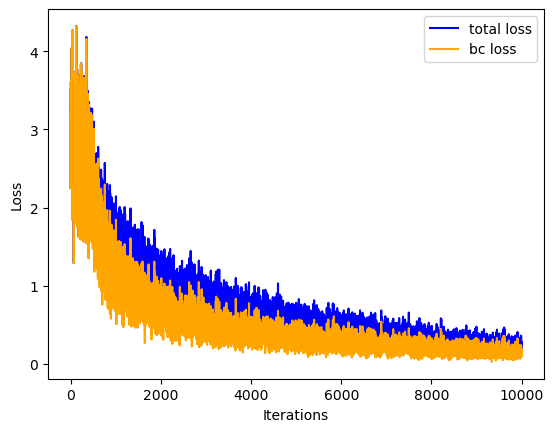

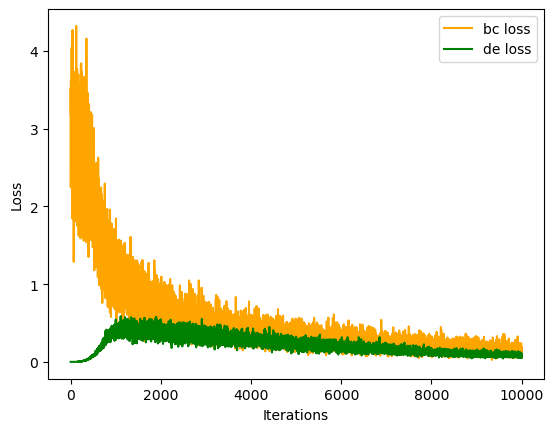

In [ ]:
plt.figure(1)
plt.plot(np.arange(iterations), losses['loss'], label='total loss', color='blue')
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.plot(np.arange(iterations), losses['loss_de'], label='de loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.show()

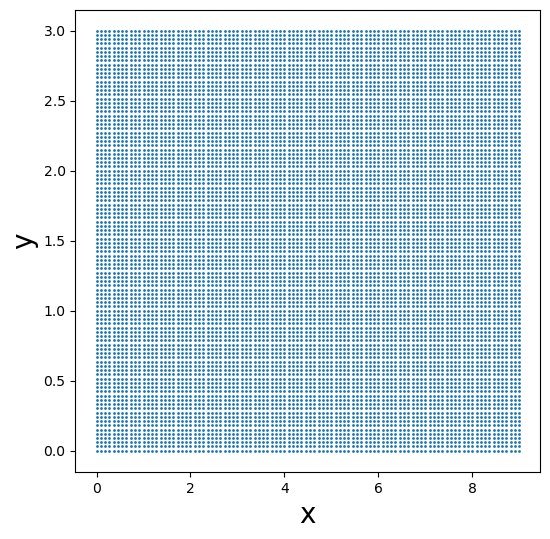

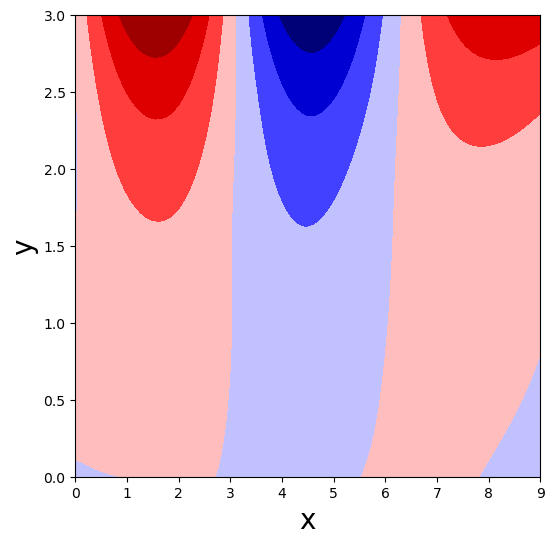

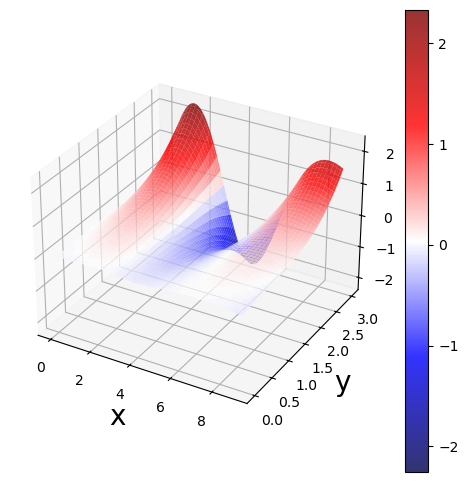

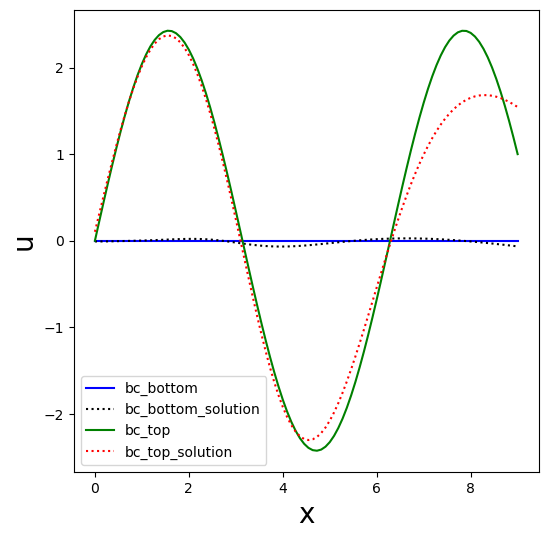

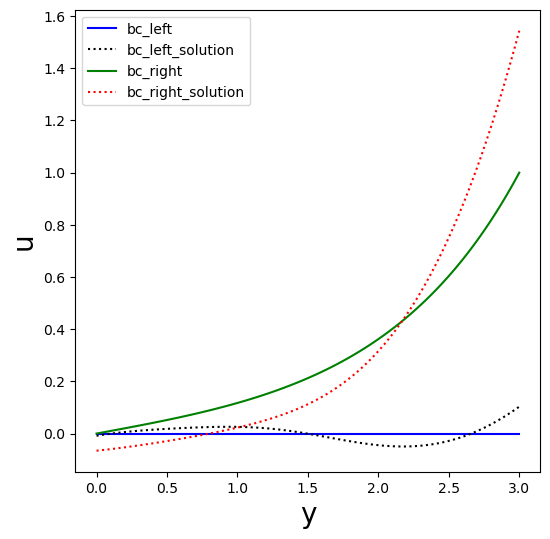

In [ ]:
u_test(u_NN)

## Mini-batch

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class BoundaryDataset(Dataset):
    def __init__(self, bc_points):
        b, t, l, r = bc_points
        self.x_bottom, self.y_bottom = b[0], b[1]
        self.x_top, self.y_top = t[0], t[1]
        self.x_left, self.y_left = l[0], l[1]
        self.x_right, self.y_right = r[0], r[1]
    
    def __len__(self):
        return len(self.x_bottom)
    
    def __getitem__(self, idx):
        x_bottom, y_bottom = self.x_bottom[idx], self.y_bottom[idx]
        x_top, y_top = self.x_top[idx], self.y_top[idx]
        x_left, y_left = self.x_left[idx], self.y_left[idx]
        x_right, y_right = self.x_right[idx], self.y_right[idx]
        return [[x_bottom, y_bottom], [x_top, y_top], [x_left, y_left], [x_right, y_right]]

class CollocationDataset(Dataset):
    def __init__(self, co_points):        
        self.x_co, self.y_co = co_points
        
    def __len__(self):
        return len(self.x_co)

    def __getitem__(self, idx):
        x_co, y_co = self.x_co[idx], self.y_co[idx]
        return [x_co, y_co]

In [ ]:
# boundary points
N_bc = 128

x_bottom = torch.FloatTensor(N_bc, 1).uniform_(0, a).to(device)
y_bottom = torch.zeros(N_bc, 1).to(device)

x_top = torch.FloatTensor(N_bc, 1).uniform_(0, a).to(device)
y_top = torch.full((N_bc, 1), b).to(device)

x_left = torch.zeros(N_bc, 1).to(device)
y_left = torch.FloatTensor(N_bc, 1).uniform_(0, b).to(device)

x_right = torch.full((N_bc, 1), a).to(device)
y_right = torch.FloatTensor(N_bc, 1).uniform_(0, b).to(device)
    
# collocation points
N_co = 128

x_co = torch.FloatTensor(N_co, 1).uniform_(0, a)
x_co.requires_grad = True
x_co = x_co.to(device)

y_co = torch.FloatTensor(N_co, 1).uniform_(0, b)
y_co.requires_grad = True
y_co = y_co.to(device)

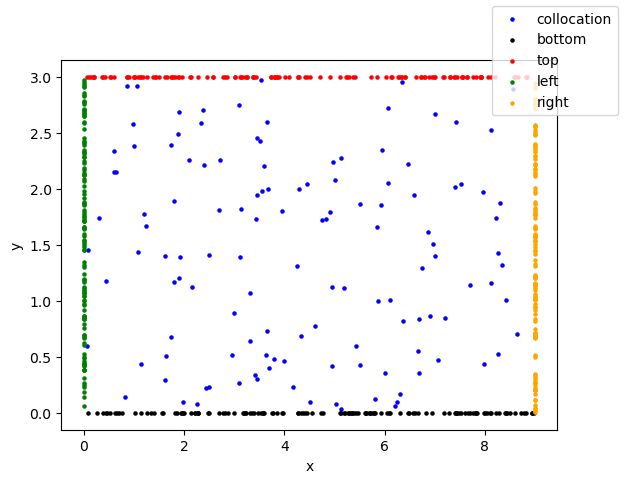

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x_co.detach().cpu().numpy(), y_co.detach().cpu().numpy(), color='blue', label='collocation', s=5)
ax.scatter(x_bottom.detach().cpu().numpy(), y_bottom.detach().cpu().numpy(), color='black', label='bottom', s=5)
ax.scatter(x_top.detach().cpu().numpy(), y_top.detach().cpu().numpy(), color='red', label='top', s=5)
ax.scatter(x_left.detach().cpu().numpy(), y_left.detach().cpu().numpy(), color='green', label='left', s=5)
ax.scatter(x_right.detach().cpu().numpy(), y_right.detach().cpu().numpy(), color='orange', label='right', s=5)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.legend()
plt.show()

In [ ]:
# dataset
bc_points = [[x_bottom, y_bottom], [x_top, y_top], [x_left, y_left], [x_right, y_right]]
bc_dataset = BoundaryDataset(bc_points)
bc_dataloader = DataLoader(bc_dataset, batch_size=N_bc//4, shuffle=True)

co_points = [x_co, y_co]
co_dataset = CollocationDataset(co_points)
co_dataloader = DataLoader(co_dataset, batch_size=N_co//4, shuffle=True)

In [ ]:
# Solution function u as Neural Networks
u_NN = MLP().to(device)

# Optimizer
optimizer = torch.optim.Adam(u_NN.parameters(), lr=0.001)

# Loss function
mseloss = nn.MSELoss(reduction='mean')
lambda_bc = 1
lambda_de = 1

# Iterations
iterations = 10000

losses = {'loss':[], 'loss_bc':[], 'loss_de':[]}

t1 = perf_counter()
tqdm_iter = tqdm(range(iterations))
for i in tqdm_iter:
    for batch_idx, (bc_points, co_points) in enumerate(zip(bc_dataloader, co_dataloader)):
        [x_bottom, y_bottom], [x_top, y_top], [x_left, y_left], [x_right, y_right] = bc_points
        x_co, y_co = co_points
        
        # Boundary Conditions
        u_pred_bottom = u_NN(x_bottom, y_bottom)
        u_pred_top = u_NN(x_top, y_top)
        u_pred_left = u_NN(x_left, y_left)
        u_pred_right = u_NN(x_right, y_right)
        
        u_bc_bottom = torch.full((len(u_pred_bottom), 1), 0.0).to(device)
        u_bc_top = torch.sin(x_top) / np.sin(a)
        u_bc_left = torch.full((len(u_pred_bottom), 1), 0.0).to(device)
        u_bc_right = torch.sinh(y_right) / np.sinh(b)

        loss_bc_bottom = mseloss(u_pred_bottom, u_bc_bottom)
        loss_bc_top = mseloss(u_pred_top, u_bc_top)
        loss_bc_left = mseloss(u_pred_left, u_bc_left)
        loss_bc_right = mseloss(u_pred_right, u_bc_right)

        loss_bc = loss_bc_bottom + loss_bc_top + loss_bc_left + loss_bc_right

        # Differential Equations
        u_pred = u_NN(x_co, y_co)

        u_pred_x = torch.autograd.grad(u_pred, x_co, torch.ones_like(u_pred), create_graph=True)[0]
        u_pred_xx = torch.autograd.grad(u_pred_x, x_co, torch.ones_like(u_pred), create_graph=True)[0]

        u_pred_y = torch.autograd.grad(u_pred, y_co, torch.ones_like(u_pred), create_graph=True)[0]
        u_pred_yy = torch.autograd.grad(u_pred_y, y_co, torch.ones_like(u_pred), create_graph=True)[0]

        loss_de = mseloss(u_pred_xx+u_pred_yy, torch.zeros_like(u_pred_yy).to(device))

        loss = lambda_bc*loss_bc + lambda_de*loss_de

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

    losses['loss'].append(loss.item())
    losses['loss_bc'].append(lambda_bc*loss_bc.item())
    losses['loss_de'].append(lambda_de*loss_de.item())
    if i==0 or i % 100 == 0 or i==iterations-1:
        # print(f'Iteration: {i} / Loss {loss}')
        tqdm_iter.set_postfix_str(f'Loss: {loss.item():.2e}')
t2 = perf_counter()

print('{} seconds'.format(t2-t1))

100%|██████████| 10000/10000 [06:40<00:00, 24.99it/s, Loss: 4.36e-04]

394.640217031003 seconds


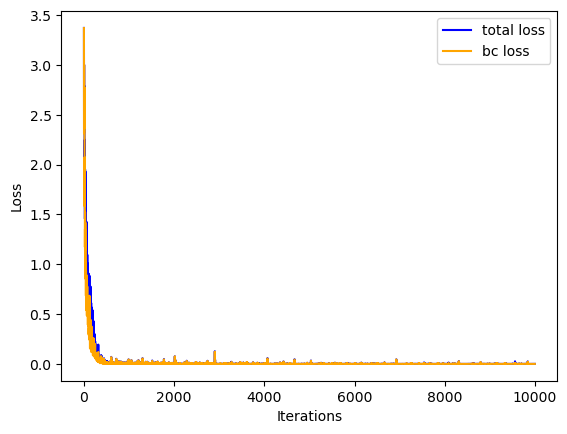

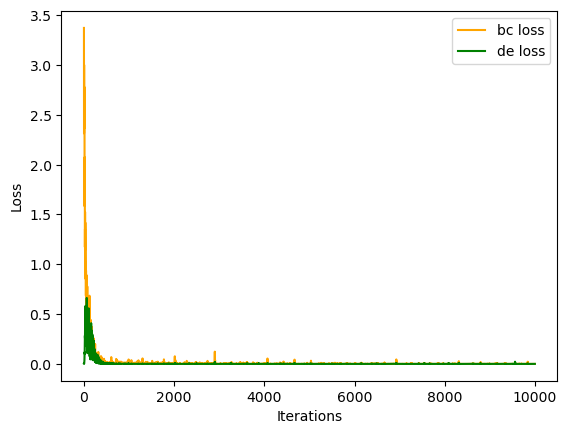

In [ ]:
plt.figure(1)
plt.plot(np.arange(iterations), losses['loss'], label='total loss', color='blue')
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(np.arange(iterations), losses['loss_bc'], label='bc loss', color='orange')
plt.plot(np.arange(iterations), losses['loss_de'], label='de loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.show()

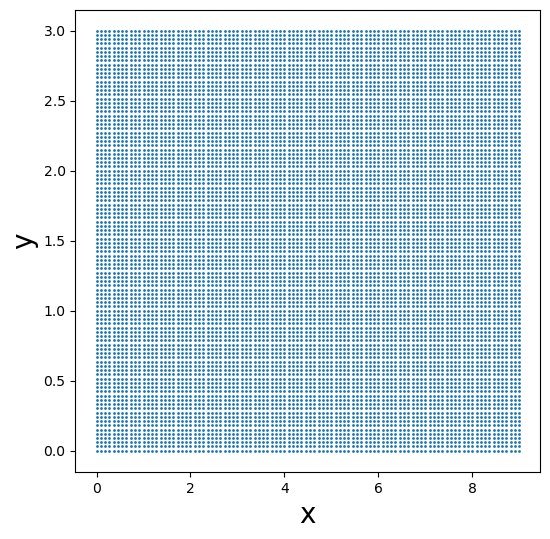

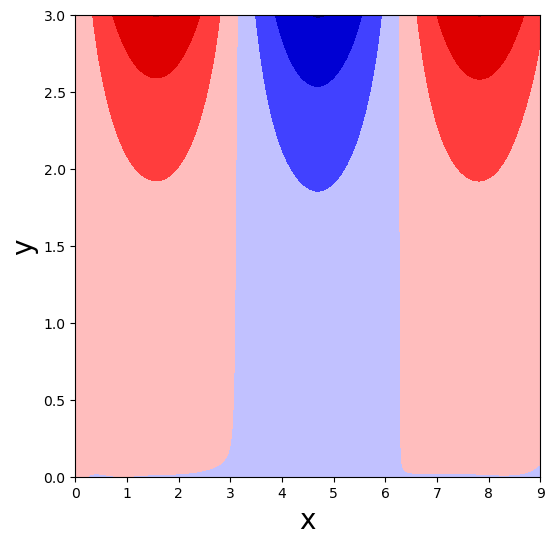

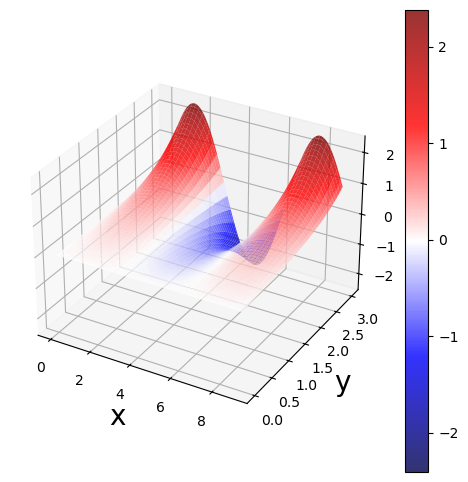

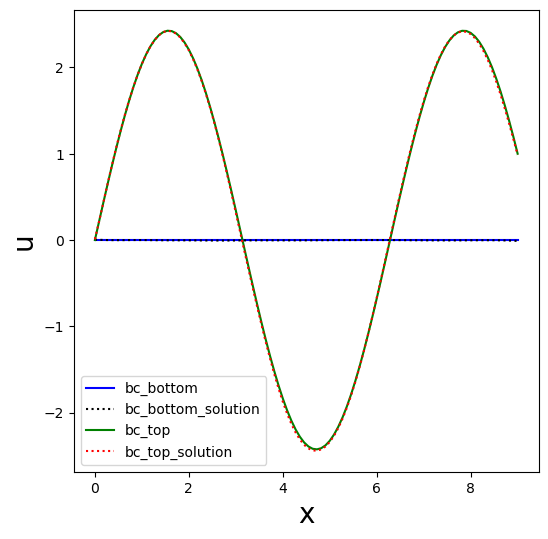

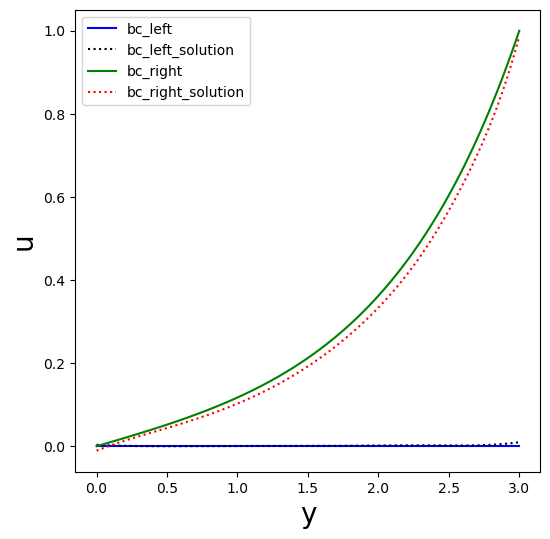

In [ ]:
u_test(u_NN)